# IMU Calibration

In [1]:
import numpy as np
import pandas as pd

import scipy.optimize

import matplotlib.pyplot as plt

## Load session

In [2]:
# Load CSV dump
path = "../data/calibrate_imu_idle.csv"
columns = ["cpu_time", "imu_time", "ax", "ay", "az", "gx", "gy", "gz", "k"]
df = pd.read_csv(path, names=columns)
df

,cpu_time,imu_time,ax,ay,az,gx,gy,gz,k
0,227542100,287593,0.6449,9.7208,0.9906,0.0195,-0.0599,-0.0232,19.45
1,239194800,287604,0.6389,9.7304,0.9918,0.0195,-0.0586,-0.0257,19.52
2,250302900,287616,0.6437,9.7232,0.9894,0.0195,-0.0562,-0.0293,19.52
3,261421500,287627,0.6544,9.7256,0.9739,0.0195,-0.0562,-0.0281,19.44
4,272620200,287638,0.6497,9.7161,0.9823,0.0195,-0.0599,-0.0244,19.44
...,...,...,...,...,...,...,...,...,...
23334,263094791900,550460,-9.4098,-2.4227,1.8281,0.0183,-0.0562,-0.0281,19.87
23335,263106259000,550471,-9.4170,-2.4287,1.8365,0.0195,-0.0574,-0.0281,19.87
23336,263117449800,550482,-9.4134,-2.4311,1.8461,0.0195,-0.0574,-0.0293,19.91
23337,263128538100,550494,-9.4062,-2.4287,1.8449,0.0183,-0.0574,-0.0293,19.91


In [3]:
# Time is in milliseconds, let us use seconds instead
T = df["imu_time"].values * 1e-3

# Gyroscope is in radians per second
G = df[["gx", "gy", "gz"]].values

# Accelerometer is in meters per second squared
A = df[["ax", "ay", "az"]].values

In [4]:
# Sampling is roughly 90Hz
sample_rate = 1.0 / np.median(np.diff(T))
sample_rate

90.90909090889173

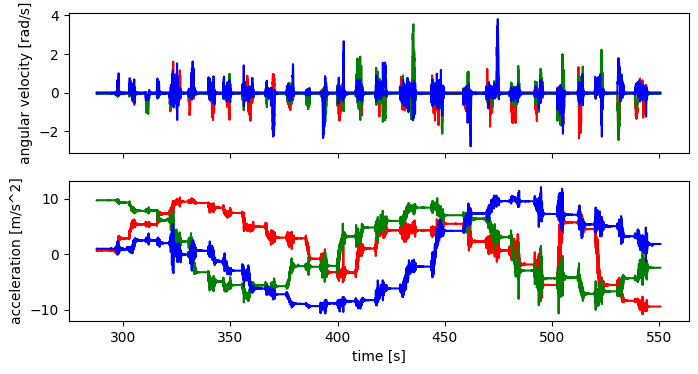

In [5]:
# Show original plot
_, axes = plt.subplots(2, sharex=True, figsize=(8, 4))

# Gyroscope
axes[0].plot(T, G[:, 0], c="r")
axes[0].plot(T, G[:, 1], c="g")
axes[0].plot(T, G[:, 2], c="b")
axes[0].set_ylabel("angular velocity [rad/s]")

# Accelerometer
axes[1].plot(T, A[:, 0], c="r")
axes[1].plot(T, A[:, 1], c="g")
axes[1].plot(T, A[:, 2], c="b")
axes[1].set_xlabel("time [s]")
axes[1].set_ylabel("acceleration [m/s^2]")

plt.show()

## Find idle phases

In [6]:
# One-second sliding windows
window_size = int(sample_rate)
W = np.lib.stride_tricks.sliding_window_view(G, window_size, axis=0)
W.shape

(23250, 3, 90)

In [7]:
# Compute standard deviation
stds = W.std(axis=2)
stds.min(axis=0)

array([0.        , 0.00037924, 0.00028253])

In [8]:
# Search for stable windows
threshold = 0.005
is_stable = (stds < threshold).all(axis=1)
is_stable = np.pad(
    is_stable, [(window_size // 2, G.shape[0] - is_stable.shape[0] - window_size // 2)]
)

In [9]:
# Extract indices
indices = np.arange(1, is_stable.shape[0])
starts = indices[~is_stable[:-1] & is_stable[1:]]
ends = indices[is_stable[:-1] & ~is_stable[1:]]
assert starts.shape == ends.shape
starts.shape[0]

31

In [10]:
# Remove short windows
min_duration = 2.0
durations = T[ends] - T[starts]
is_meaningful = durations >= min_duration
starts = starts[is_meaningful]
ends = ends[is_meaningful]
starts.shape[0]

25

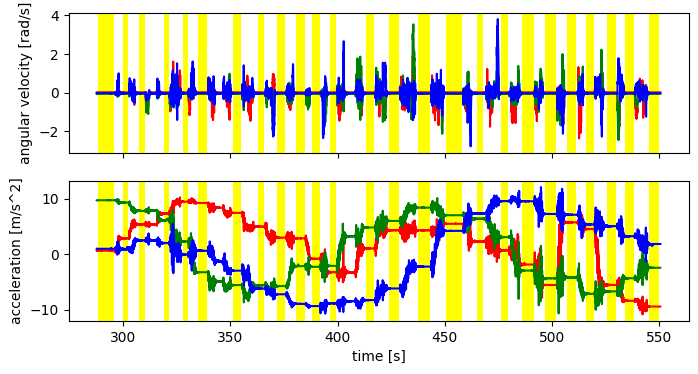

In [11]:
# Show original plot
_, axes = plt.subplots(2, sharex=True, figsize=(8, 4))

# Gyroscope
axes[0].plot(T, G[:, 0], c="r")
axes[0].plot(T, G[:, 1], c="g")
axes[0].plot(T, G[:, 2], c="b")
axes[0].set_ylabel("angular velocity [rad/s]")

# Accelerometer
axes[1].plot(T, A[:, 0], c="r")
axes[1].plot(T, A[:, 1], c="g")
axes[1].plot(T, A[:, 2], c="b")
axes[1].set_xlabel("time [s]")
axes[1].set_ylabel("acceleration [m/s^2]")

# Add idle bands
for ax in axes:
    for start, end in zip(starts, ends):
        ax.axvspan(T[start], T[end], fc="yellow")

plt.show()

## Check spherical distribution

In [12]:
# Aggregate slices
A_means = np.zeros((len(starts), 3))
A_stds = np.zeros((len(starts), 3))
G_means = np.zeros((len(starts), 3))
G_stds = np.zeros((len(starts), 3))
for i, (start, end) in enumerate(zip(starts, ends)):
    A_i = A[start:end]
    A_means[i] = np.mean(A_i, axis=0)
    A_stds[i] = np.std(A_i, axis=0)
    G_i = G[start:end]
    G_means[i] = np.mean(G_i, axis=0)
    G_stds[i] = np.std(G_i, axis=0)

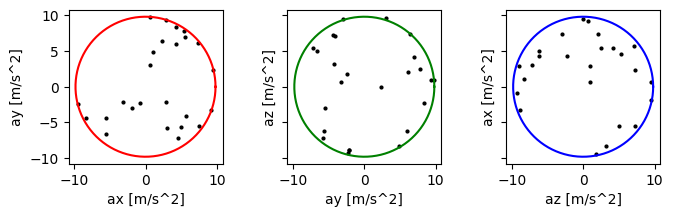

In [13]:
_, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(8, 2))

# Circle, representing theoretical gravity contribution
theta = np.linspace(0, 2 * np.pi, 100)
g = 9.81
cx = g * np.cos(theta)
cy = g * np.sin(theta)

# XY plane
axes[0].plot(cx, cy, c="r")
axes[0].scatter(A_means[:, 0], A_means[:, 1], c="k", s=4)
axes[0].set_aspect("equal")
axes[0].set_xlabel("ax [m/s^2]")
axes[0].set_ylabel("ay [m/s^2]")

# YZ plane
axes[1].plot(cx, cy, c="g")
axes[1].scatter(A_means[:, 1], A_means[:, 2], c="k", s=4)
axes[1].set_aspect("equal")
axes[1].set_xlabel("ay [m/s^2]")
axes[1].set_ylabel("az [m/s^2]")

# ZX plane
axes[2].plot(cx, cy, c="b")
axes[2].scatter(A_means[:, 2], A_means[:, 0], c="k", s=4)
axes[2].set_aspect("equal")
axes[2].set_xlabel("az [m/s^2]")
axes[2].set_ylabel("ax [m/s^2]")

plt.show()

## Estimate accelerometer biases

In [14]:
# We are going to fit an axis-aligned ellipsoid to our accelerometer measurements
points = A_means

# Loss function that we need to minimize
# Note: this is based on the fact that a calibrated accelerometer affected by gravity only should report a unit vector
def f(param):
    offset = param[:3]
    scale = param[3:]
    true = points * scale[None, :] + offset[None, :]
    norm = np.sqrt((true ** 2).sum(axis=1))
    losses = (norm - 1) ** 2
    loss = losses.sum()
    return loss

# Initial guess is a perfect sphere
g = 9.81
x0 = np.array([0.0, 0.0, 0.0, 1.0 / g, 1.0 / g, 1.0 / g])

# Optimize
result = scipy.optimize.minimize(f, x0)
assert result.success
result.nit, result.fun

(11, 1.8400483236127247e-05)

In [15]:
# Here is our calibration
offset = result.x[:3]
scale = result.x[3:]
offset, scale

(array([ 0.00456531,  0.00791233, -0.02643263]),
 array([0.10216491, 0.10159286, 0.10136561]))

In [16]:
# TODO we should calibrate for misalignment (i.e. axes not being perfectly orthogonal)

In [17]:
# Hence, corrected measurements are given by
A_fixed = A * scale[None, :] + offset[None, :]

## Estimate gyroscope biases

In [18]:
# Gyroscope offset should not be affected by actual orientation
G_means

array([[ 0.01968569, -0.05824769, -0.02622847],
       [ 0.01958066, -0.05796557, -0.02651934],
       [ 0.01944553, -0.05811149, -0.02781532],
       [ 0.0196185 , -0.0579775 , -0.027486  ],
       [ 0.01964239, -0.05780598, -0.02765707],
       [ 0.01952956, -0.05773933, -0.02792314],
       [ 0.01951232, -0.05795073, -0.03029091],
       [ 0.01968217, -0.0579549 , -0.0289993 ],
       [ 0.01956322, -0.05787126, -0.02700632],
       [ 0.01960163, -0.05772168, -0.0281748 ],
       [ 0.01948973, -0.0577148 , -0.02643625],
       [ 0.01943608, -0.05777176, -0.0255702 ],
       [ 0.01943971, -0.05750696, -0.02996145],
       [ 0.01953117, -0.05768329, -0.02887307],
       [ 0.01939218, -0.05771008, -0.03857016],
       [ 0.01936999, -0.0577754 , -0.04057526],
       [ 0.01925075, -0.05721015, -0.03753496],
       [ 0.01901971, -0.05723047, -0.03424444],
       [ 0.01910086, -0.05726245, -0.03273026],
       [ 0.01921468, -0.05712957, -0.03227872],
       [ 0.01934893, -0.05726578, -0.031

In [19]:
# Compute offset bias
offset = -G_means.mean(axis=0)
offset

array([-0.019417  ,  0.05761032,  0.03028953])

In [20]:
# TODO we should do some sensitivity calibration, at some point
# (e.g. place the IMU on a rotating plate, and do exactly 360°; integrated angular velocity should match)

In [21]:
# TODO we should calibrate for misalignment (i.e. axes not being perfectly orthogonal)

In [22]:
# Hence, corrected measurements are given by
G_fixed = G + offset[None, :]